# Synthetic Brand Generation with GANs

## Project Goal
Generate synthetic brand data to address class imbalance in hierarchical clustering using:
- **CTGAN**: For generating realistic brand features (ESG metrics, demographics, business characteristics)
- **DistilGPT2**: For generating realistic brand names

## Dataset
- **Source**: `data/raw/brand_information.csv`
- **Size**: 3,605 brands with 80+ features
- **Problem**: Hierarchical clustering produces only 2 clusters (severe imbalance)

## Notebook Structure
1. **Phase 1**: Data Preparation & Exploration
2. **Phase 2**: CTGAN Training (Tabular Features)
3. **Phase 3**: Brand Name Generation (DistilGPT2)
4. **Phase 4**: Synthetic Data Generation
5. **Phase 5**: Evaluation & Clustering Comparison

## Setup & Installation

In [1]:
!git clone https://github.com/dyegofern/csca5642-deep-learning.git
!pip install -q sdv transformers torch pandas numpy scikit-learn matplotlib seaborn plotly scipy

# Import libraries
import sys
import os
from google.colab import drive

MAPPED_DIR = '/content/csca5642-deep-learning'

# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DATA_PATH = MAPPED_DIR + '/data/raw/brand_information.csv'

# Set output and model directories to Google Drive
DRIVE_OUTPUT_BASE = '/content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration'
OUTPUT_DIR = os.path.join(DRIVE_OUTPUT_BASE, 'outputs')
MODEL_DIR = os.path.join(DRIVE_OUTPUT_BASE, 'models')

# Add src to path (for local imports)
src_path = MAPPED_DIR + '/src'
if src_path not in sys.path:
    sys.path.append(src_path)

# Add data to path (for local imports) - as specified by the user
data_path = MAPPED_DIR + '/data'
if data_path not in sys.path:
    sys.path.append(data_path)

Cloning into 'csca5642-deep-learning'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 56 (delta 26), reused 46 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 1.01 MiB | 17.88 MiB/s, done.
Resolving deltas: 100% (26/26), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 131.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00
Mounted at /cont

In [2]:
# Import our custom modules
from data_processor import BrandDataProcessor
from tabular_gan import TabularBrandGAN
from brand_name_generator import BrandNameGenerator
from evaluator import BrandDataEvaluator

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" All modules loaded successfully!")

 All modules loaded successfully!


## Configuration

In [3]:
# ============================================================
# CONFIGURATION
# ============================================================

# Model Loading Option
FROM_PRETRAINED = True  # Set to True to load pre-trained models, False to train from scratch

# Training parameters
CTGAN_EPOCHS = 300
CTGAN_BATCH_SIZE = 500
GPT2_EPOCHS = 3
GPT2_BATCH_SIZE = 8

# Generation parameters
MIN_BRANDS_PER_COMPANY = 10
DIVERSITY_TEMPERATURE = 0.7    # Brand name temperature (0.6-0.8 recommended)
ADD_DIVERSITY_NOISE = True     # Add 2% noise to tabular features

# Model paths
ctgan_model_path = os.path.join(MODEL_DIR, 'ctgan_brand_model.pkl')
gpt2_output_dir = os.path.join(MODEL_DIR, 'brand_name_generator')

print(f"Data path: {DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")
print(f" Configuration:")
print(f"  Load from pretrained: {FROM_PRETRAINED}")
print(f"  Min brands per company: {MIN_BRANDS_PER_COMPANY}")
print(f"  Brand name temperature: {DIVERSITY_TEMPERATURE}")
print(f"  Add diversity noise: {ADD_DIVERSITY_NOISE}")

Data path: /content/csca5642-deep-learning/data/raw/brand_information.csv
Output directory: /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration/outputs
Model directory: /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration/models
 Configuration:
  Load from pretrained: True
  Min brands per company: 10
  Brand name temperature: 0.7
  Add diversity noise: True


---
# Phase 1: Data Preparation & Exploration

Load and explore the brand dataset, then prepare it for GAN training.

## 1.1 Load Data

In [4]:
# Initialize data processor
processor = BrandDataProcessor(DATA_PATH)

# Load data
df = processor.load_data()
df.head()

Loading data from /content/csca5642-deep-learning/data/raw/brand_information.csv...
Loaded 3605 brands with 77 features


,industry_id,industry_name,deforestation_risk,labor_exploitation_risk,chemical_pollution_risk,supply_chain_greenwashing_risk,positive_innovation_risk,esg_summary,company_id,company_name,...,supply_chain_localization,product_portfolio_diversity,revenue_billion_usd,customer_loyalty_index,r_and_d_spend_percent_revenue,women_board_percent,ceo_tenure_years,market_cap_billion_usd,major_sustainability_award_last5y,references_and_links
0,10,Household & Personal Products,1,1,1,0,0,Household & Personal Products industry demonst...,125,"S. C. Johnson & Son, Inc.",...,85,2,0.04,55,0.5,20,3,0.0,0,https://www.galaxus.ch; Limited English sources
1,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,51,Ferrero Group,...,40,1,0.18,65,0.8,25,2,0.0,0,https://en.wikipedia.org/wiki/100_Grand_Bar
2,17,"Meat, Poultry & Dairy",1,1,1,0,0,"Meat, Poultry & Dairy industry faces severe ES...",96,Foremost Farms USA Cooperative,...,90,1,0.02,70,0.1,15,4,0.0,0,https://www.foremostfarms.com/foremost-farms-a...
3,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,95,"Wells Enterprises, Inc.",...,70,2,0.03,72,0.5,20,3,0.0,0,http://www.onsecondscoop.com/2014/04/2nd-st-cr...
4,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,10,"Mars, Incorporated",...,45,1,0.25,72,0.8,25,3,0.0,0,https://www.businessinsider.com/mars-inc-famil...


## 1.2 Exploratory Data Analysis


=== Data Exploration ===
Total brands: 3605
Total features: 77

Top 10 companies by brand count:
  Nestle: 126 brands
  Bayer: 95 brands
  Conagra Brands Inc.: 94 brands
  Hershey Company: 79 brands
  General Mills: 75 brands
  JBS USA: 74 brands
  PepsiCo, Inc.: 69 brands
  Ferrero Group: 69 brands
  Ajinomoto: 62 brands
  Target: 58 brands


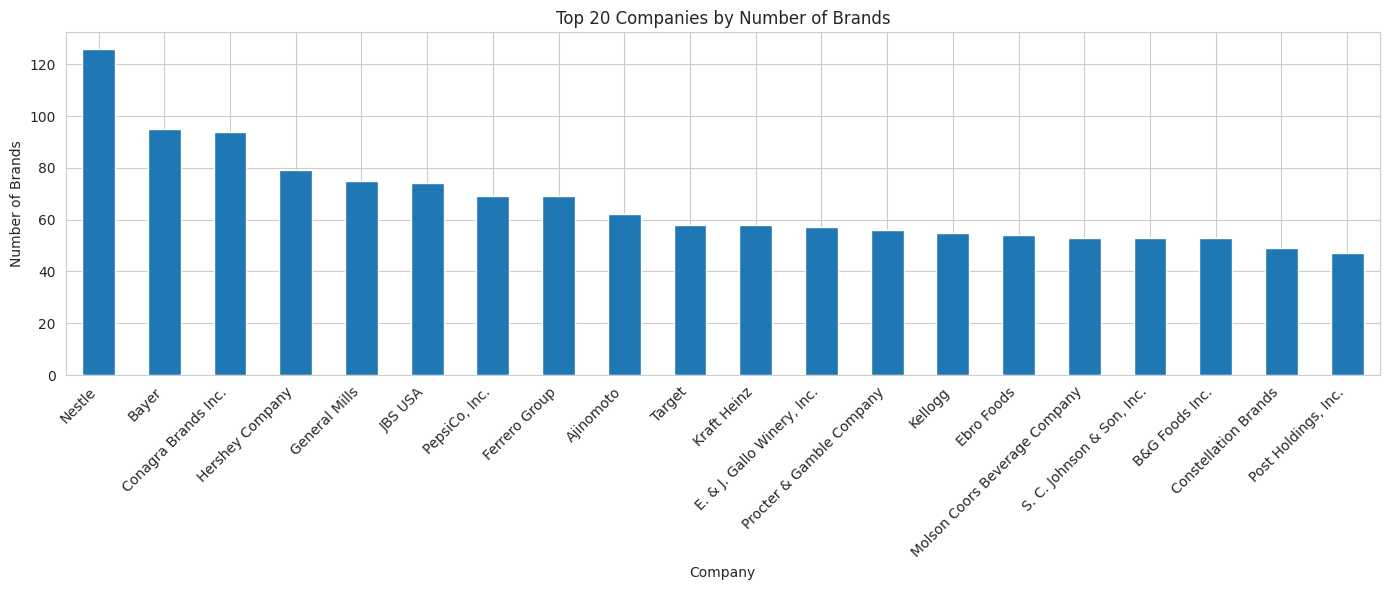


Companies with 1 brand: 40
Companies with 20+ brands: 60
Companies with 50+ brands: 18


In [5]:
# Explore the dataset
stats = processor.explore_data()

# Visualize brands per company
brand_counts = pd.Series(stats['brands_per_company'])
top_companies = brand_counts.head(20)

plt.figure(figsize=(14, 6))
top_companies.plot(kind='bar')
plt.title('Top 20 Companies by Number of Brands')
plt.xlabel('Company')
plt.ylabel('Number of Brands')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nCompanies with 1 brand: {(brand_counts == 1).sum()}")
print(f"Companies with 20+ brands: {(brand_counts >= 20).sum()}")
print(f"Companies with 50+ brands: {(brand_counts >= 50).sum()}")

In [6]:
# Identify multi-brand companies (good for training)
multi_brand_companies = processor.get_multi_brand_companies(min_brands=10)

print(f"\nIdentified {len(multi_brand_companies)} companies with 10+ brands")
print("\nExample companies:")
for company in multi_brand_companies[:10]:
    n_brands = len(processor.get_company_brands(company))
    print(f"  {company}: {n_brands} brands")


Found 101 companies with 10+ brands

Identified 101 companies with 10+ brands

Example companies:
  Nestle: 126 brands
  Bayer: 95 brands
  Conagra Brands Inc.: 94 brands
  Hershey Company: 79 brands
  General Mills: 75 brands
  JBS USA: 74 brands
  PepsiCo, Inc.: 69 brands
  Ferrero Group: 69 brands
  Ajinomoto: 62 brands
  Target: 58 brands


## 1.3 Data Cleaning & Preprocessing

In [7]:
# Clean the data
df_clean = processor.clean_data(drop_text_heavy=True)

# Check for missing values
missing = df_clean.isnull().sum()
print(f"\nRemaining missing values: {missing[missing > 0]}")


=== Data Cleaning ===

Identified 54 numerical features
Identified 7 categorical features
Identified 6 text features (will be handled separately)
Dropped text-heavy columns: ['esg_summary', 'accusation', 'references_and_links']

Handling missing values...
  Filled demographics_gender with mode/Unknown
  Filled demographics_lifestyle with mode/Unknown

Cleaned dataset: 3605 rows, 74 columns

Remaining missing values: fossil_fuel_reliance      146
esg_programs              146
sustainability_actions    146
target_population         146
main_partnerships         146
dtype: int64


In [8]:
# Prepare data for GAN training
train_df, val_df = processor.prepare_for_gan(test_size=0.25)

print(f"\nTraining set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"\nFeatures for GAN: {list(train_df.columns)}")


=== Preparing Data for GAN ===

Encoding categorical features...
  Encoded industry_name: 14 unique values
  Encoded country_of_origin: 42 unique values
  Encoded headquarters_country: 43 unique values
  Encoded demographics_income_level: 84 unique values
  Encoded demographics_geographic_reach: 167 unique values
  Encoded demographics_gender: 49 unique values
  Encoded demographics_lifestyle: 3540 unique values
  Encoded company_name: 243 companies
Added 40 single-brand companies to training set.

Train set: 2713 brands
Validation set: 892 brands

Training set shape: (2713, 62)
Validation set shape: (892, 62)

Features for GAN: ['company_name', 'industry_name', 'country_of_origin', 'headquarters_country', 'demographics_income_level', 'demographics_geographic_reach', 'demographics_gender', 'demographics_lifestyle', 'deforestation_risk', 'labor_exploitation_risk', 'chemical_pollution_risk', 'supply_chain_greenwashing_risk', 'positive_innovation_risk', 'scope_v_revenues', 'reported_scop

---
# Phase 2: CTGAN Training (Tabular Features)

Train CTGAN to generate realistic brand features conditioned on company name.

## 2.1 Initialize and Train CTGAN

In [9]:
# Initialize CTGAN
ctgan = TabularBrandGAN(
    epochs=CTGAN_EPOCHS,
    batch_size=CTGAN_BATCH_SIZE,
    verbose=True
)

# Identify discrete columns (categorical features that were encoded)
discrete_cols = processor.categorical_features + ['company_name']
discrete_cols = [col for col in discrete_cols if col in train_df.columns]

print(f"Discrete columns for CTGAN: {discrete_cols}")

Discrete columns for CTGAN: ['industry_name', 'country_of_origin', 'headquarters_country', 'demographics_income_level', 'demographics_geographic_reach', 'demographics_gender', 'demographics_lifestyle', 'company_name']


In [10]:
# Train or load CTGAN model
if FROM_PRETRAINED and os.path.exists(ctgan_model_path):
    print("Loading pre-trained CTGAN model...")
    ctgan.load_model(ctgan_model_path)
else:
    if FROM_PRETRAINED:
        print("Pre-trained model not found, training from scratch...")
    else:
        print("Training new CTGAN model...")

    # Train CTGAN (this may take 10-30 minutes depending on GPU)
    ctgan.train(train_df, discrete_columns=discrete_cols)

    # Save the trained model
    ctgan.save_model(ctgan_model_path)

Loading pre-trained CTGAN model...
Model loaded from /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration/models/ctgan_brand_model.pkl


## 2.2 Test CTGAN Generation

In [11]:
# Test: Generate 5 synthetic brands for a specific company
test_company = multi_brand_companies[0]
test_company_encoded = processor.label_encoders['company_name'].transform([test_company])[0]

print(f"Testing generation for: {test_company} (encoded: {test_company_encoded})")

test_synthetic = ctgan.generate(
    n_samples=5,
    condition_column='company_name',
    condition_value=test_company_encoded
)

# Decode and display
test_decoded = processor.decode_categorical(test_synthetic)
test_decoded.head()

Testing generation for: Nestle (encoded: 156)

=== Generating 5 Synthetic Brands ===
Conditioning on company_name = 156


Sampling remaining columns: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

Generated 5 synthetic samples


,company_name,industry_name,country_of_origin,headquarters_country,demographics_income_level,demographics_geographic_reach,demographics_gender,demographics_lifestyle,deforestation_risk,labor_exploitation_risk,...,branding_innovation_level,supply_chain_localization,product_portfolio_diversity,revenue_billion_usd,customer_loyalty_index,r_and_d_spend_percent_revenue,women_board_percent,ceo_tenure_years,market_cap_billion_usd,major_sustainability_award_last5y
0,Nestle,Processed Foods,United States,United States,All income levels,National,All genders,QT Twister consumers,1,1,...,1,60.0,2,0.9347,16.0,1.0,25.0,2,0.68,0
1,Nestle,Household & Personal Products,Chile,United States,All income levels,"United States, Hispanic communities strong",All genders,Carnation consumers,1,0,...,0,59.0,2,0.0000,93.0,0.7,0.0,0,0.00,0
2,Nestle,Drug Retailers,United States,United States,"Premium-income, fashion","United States (2,000+ stores expanding)","Primary: women, all genders",Bridge Mixture consumers,1,1,...,2,0.0,2,0.0000,83.0,0.0,0.0,0,0.00,0
3,Nestle,Processed Foods,Sweden,Vietnam,All income levels,United States (national),All genders,Farmland consumers,1,1,...,0,68.0,2,0.0000,86.0,0.0,0.0,2,0.00,0
4,Nestle,Processed Foods,Venezuela,United States,All income levels,Netherlands,All genders,Katy Perry consumers,0,1,...,1,60.0,2,1.5387,71.0,1.0,25.0,2,0.00,0


---
# Phase 3: Brand Name Generation (DistilGPT2)

Fine-tune DistilGPT2 to generate realistic brand names.

## 3.1 Prepare Brand Name Training Data

In [12]:
# Prepare dataframe with brand_name, company_name, industry_name
brand_name_df = df_clean[['brand_name', 'company_name', 'industry_name']].dropna()

print(f"Brand name training data: {len(brand_name_df)} examples")
print("\nExample training data:")
brand_name_df.head(10)

Brand name training data: 3605 examples

Example training data:


,brand_name,company_name,industry_name
0,00 Null Null,"S. C. Johnson & Son, Inc.",Household & Personal Products
1,100 Grand,Ferrero Group,Processed Foods
2,1950 127 Cheese,Foremost Farms USA Cooperative,"Meat, Poultry & Dairy"
3,2nd Street Creamery,"Wells Enterprises, Inc.",Processed Foods
4,3 Musketeers,"Mars, Incorporated",Processed Foods
5,365 by Whole Foods Market,Amazon,E-commerce
6,40 Knots Seafood,Associated Food Stores,Processed Foods
7,4Grain,"Cal-Maine Foods, Inc.","Meat, Poultry & Dairy"
8,5 Star Beef,JBS USA,"Meat, Poultry & Dairy"
9,5th Avenue,Hershey Company,Processed Foods


## 3.2 Fine-tune DistilGPT2

In [13]:
# Initialize brand name generator
name_generator = BrandNameGenerator(model_name='distilgpt2')

# Prepare model
name_generator.prepare_model()

Using device: cuda

Loading distilgpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on cuda


In [14]:
# Train or load brand name generator
if FROM_PRETRAINED and os.path.exists(gpt2_output_dir):
    print("Loading pre-trained brand name generator...")
    name_generator.load_model(gpt2_output_dir)
else:
    if FROM_PRETRAINED:
        print("Pre-trained model not found, training from scratch...")
    else:
        print("Training new brand name generator...")

    # Fine-tune on brand names (this may take 15-30 minutes)
    name_generator.fine_tune(
        brands_df=brand_name_df,
        epochs=GPT2_EPOCHS,
        batch_size=GPT2_BATCH_SIZE,
        output_dir=gpt2_output_dir
    )

Loading pre-trained brand name generator...
Loading model from /content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration/models/brand_name_generator...
Model loaded on cuda


## 3.3 Test Brand Name Generation

In [15]:
# Test: Generate brand names for different companies
test_companies = [
    ('PepsiCo, Inc.', 'Non-Alcoholic Beverages'),
    ('Mars, Incorporated', 'Processed Foods'),
    ('Nestle', 'Processed Foods')
]

for company, industry in test_companies:
    print(f"\n{'='*60}")
    print(f"Company: {company}")
    print(f"Industry: {industry}")
    print(f"{'='*60}")

    generated_names = name_generator.generate_brand_names(
        company_name=company,
        industry_name=industry,
        n_names=10,
        temperature=0.8
    )

    print("\nGenerated brand names:")
    for i, name in enumerate(generated_names, 1):
        print(f"  {i}. {name}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Company: PepsiCo, Inc.
Industry: Non-Alcoholic Beverages

Generated brand names:
  1. Tasty & Smart Ones Plus Premium Soda Mix (or the
  2. Oatsworth Coffee Co., Inc
  3. G&S Fresh & Easy to Wholesome!
  4. Tambiouville, New York City–Style Mountain Dew
  5. Rice Krispies 2nd Estate Scotch Ale Reserve
  6. Bimbo’s Premium Blend Coffee Crunchs™ Series of
  7. Red Hot Chili Peppers 2nd Choice Scotch Ale
  8. Blue Ribbon Coffee Reserve (Catchings) of the
  9. Jack Daniel's Pub
  10. Kwik Jack's Pizza Hut in Redford Park, Illinois 

Company: Mars, Incorporated
Industry: Processed Foods

Generated brand names:
  1. Earth's Best Food Retailers & Distributors
  2. Friesh's Super Bowl Liqueur Creamery by Tasty
  3. La Fontera Cuisine (salt) Original Recipe
  4. Blue Ribbon Cheese's Creamery by B&J & Jopie's in
  5. Diversey's Natural Foods — Original
  6. Chocardi Gras Supermarket Specialty Market on
  7. The Super Goodness of Nature's Best Value Snacks!
  8. Pecanis Bitesuit Recipechensicle 

---
# Phase 4: Synthetic Data Generation

Generate synthetic brands combining CTGAN features + DistilGPT2 names.

In [16]:
from tabular_gan import calculate_generation_targets

# Calculate how many brands to generate for each company
# This ensures minimum 100 brands per company (configurable)
generation_targets = calculate_generation_targets(
    data=train_df,
    company_column='company_name',
    min_brands_per_company=MIN_BRANDS_PER_COMPANY
)

print(f"Total synthetic brands to generate: {sum(generation_targets.values())}")


=== Generation Targets ===
  Total companies: 243
  Total brands to generate: 1868
  Average per company: 7.7

  Top 10 companies to augment:
    156: +10 brands
    24: +10 brands
    53: +10 brands
    99: +10 brands
    83: +10 brands
    112: +10 brands
    170: +10 brands
    75: +10 brands
    7: +10 brands
    67: +10 brands
Total synthetic brands to generate: 1868


In [17]:
brand_counts = df['company_name'].value_counts()

# Identify companies with few brands (candidates for augmentation)
companies_needing_brands = brand_counts[brand_counts < MIN_BRANDS_PER_COMPANY].index.tolist()

print(f"Companies with < {MIN_BRANDS_PER_COMPANY} brands: {len(companies_needing_brands)}")
print(f"\nI'll generate synthetic brands for {min(150, len(companies_needing_brands))} companies")

target_companies = companies_needing_brands[:150]
brands_per_company = 10 #max(2, N_SYNTHETIC_BRANDS // len(target_companies))

Companies with < 10 brands: 142

I'll generate synthetic brands for 142 companies


In [18]:
# Generate synthetic features using efficient stratified generation
print(" Generating synthetic brand features...")

import time
start_time = time.time()

synthetic_features = ctgan.generate_stratified(
    company_distribution=generation_targets,
    verbose=True
)

elapsed = time.time() - start_time
print(f"Generation completed in {elapsed/60:.2f} minutes")
print(f"  Average: {elapsed/len(synthetic_features):.3f}s per brand")

# Add diversity noise if enabled
if ADD_DIVERSITY_NOISE:
    print("Adding diversity noise (2%)...")
    synthetic_features = ctgan.add_diversity_noise(
        synthetic_features,
        noise_level=0.02,
        numerical_cols=processor.numerical_features
    )

print(f"Generated {len(synthetic_features)} synthetic brand feature sets")
synthetic_features.head()

 Generating synthetic brand features...

=== Stratified Generation ===
  Companies: 243
  Total brands: 1868

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 156


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 24


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 53


Sampling remaining columns:  80%|████████  | 8/10 [00:32<00:08,  4.09s/it]


Generated 8 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 99


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 83


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 112


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 170


Sampling remaining columns: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 75


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 7


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Generated 10 synthetic samples
  Progress: 10/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 67


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 125


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 216


Sampling remaining columns:  80%|████████  | 8/10 [00:32<00:08,  4.01s/it]


Generated 8 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 176


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 119


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 69


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 188


Sampling remaining columns: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 147


Sampling remaining columns: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 20


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 54


Sampling remaining columns: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


Generated 10 synthetic samples
  Progress: 20/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 173


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 101


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 56


Sampling remaining columns: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 15


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 116


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 175


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 222


Sampling remaining columns:  50%|█████     | 5/10 [00:32<00:32,  6.50s/it]


Generated 5 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 121


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 97


Sampling remaining columns: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 51


Sampling remaining columns: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


Generated 10 synthetic samples
  Progress: 30/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 193


Sampling remaining columns: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 48


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 183


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 107


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 138


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 203


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 148


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 110


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 167


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 132


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Generated 10 synthetic samples
  Progress: 40/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 190


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 106


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 42


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 12


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 111


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 63


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 126


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 219


Sampling remaining columns: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 35


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 241


Sampling remaining columns:  20%|██        | 2/10 [00:32<02:09, 16.19s/it]


Generated 2 synthetic samples
  Progress: 50/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 158


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 141


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 6


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 215


Sampling remaining columns:  70%|███████   | 7/10 [00:32<00:13,  4.58s/it]


Generated 7 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 72


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 22


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 217


Sampling remaining columns:  60%|██████    | 6/10 [00:32<00:21,  5.34s/it]


Generated 6 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 27


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 143


Sampling remaining columns: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 139


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Generated 10 synthetic samples
  Progress: 60/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 58


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 52


Sampling remaining columns: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 223


Sampling remaining columns:  40%|████      | 4/10 [00:32<00:48,  8.14s/it]


Generated 4 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 5


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 38


Sampling remaining columns: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 57


Sampling remaining columns: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 96


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 77


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 49


Sampling remaining columns: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 135


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Generated 10 synthetic samples
  Progress: 70/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 109


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 224


Sampling remaining columns:  10%|█         | 1/10 [00:32<04:50, 32.27s/it]


Generated 1 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 46


Sampling remaining columns: 100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 118


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 137


Sampling remaining columns: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 171


Sampling remaining columns: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 178


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 9


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 157


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 213


Sampling remaining columns:  90%|█████████ | 9/10 [00:32<00:03,  3.62s/it]


Generated 9 synthetic samples
  Progress: 80/243 companies...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 39


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 174


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 14


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 123


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Generated 10 synthetic samples

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 17


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Generated 10 synthetic samples

=== Generating 1 Synthetic Brands ===
Conditioning on company_name = 230


Sampling remaining columns:   0%|          | 0/1 [00:30<?, ?it/s]


ValueError: Unable to sample any rows for the given conditions. Try increasing `max_tries_per_batch` (currently: 100). Note that increasing this value will also increase the sampling time.

In [ ]:
# Encode target companies
#target_companies_encoded = [
#    processor.label_encoders['company_name'].transform([comp])[0]
#    for comp in target_companies
#]

# Generate synthetic features for each company
#synthetic_features = ctgan.generate_for_companies(
#    companies=target_companies_encoded,
#    n_per_company=brands_per_company
#)

#print(f"\nGenerated {len(synthetic_features)} synthetic brand feature sets")
#synthetic_features.head()

In [ ]:
# Decode categorical features first (so we have company/industry names for generation)
synthetic_decoded = processor.decode_categorical(synthetic_features.copy())

# Generate brand names
print("\nGenerating brand names for synthetic data...")
synthetic_with_names = name_generator.generate_for_dataframe(
    synthetic_df=synthetic_decoded,
    n_names_per_brand=3,
    temperature=0.8
)

print("\nSample synthetic brands:")
synthetic_with_names[['brand_name', 'company_name', 'industry_name']].head(20)

## 4.4 Save Synthetic Data

In [ ]:
# Save synthetic brands
synthetic_path = os.path.join(OUTPUT_DIR, 'synthetic_brands.csv')
synthetic_with_names.to_csv(synthetic_path, index=False)
print(f"Synthetic brands saved to: {synthetic_path}")

# Create augmented dataset (original + synthetic)
augmented_df = pd.concat([df_clean, synthetic_with_names], ignore_index=True)
augmented_path = os.path.join(OUTPUT_DIR, 'augmented_brands.csv')
augmented_df.to_csv(augmented_path, index=False)

print(f"\nAugmented dataset saved to: {augmented_path}")
print(f"Original brands: {len(df_clean)}")
print(f"Synthetic brands: {len(synthetic_with_names)}")
print(f"Total augmented: {len(augmented_df)}")

---
# Phase 5: Evaluation & Clustering Comparison

Evaluate synthetic data quality and compare clustering results.

## 5.1 Statistical Validation

In [ ]:
# Initialize evaluator
evaluator = BrandDataEvaluator()

# Compare distributions (using numerical features)
numerical_cols = processor.numerical_features[:10]  # Sample of numerical features

ks_results = evaluator.compare_distributions(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)

In [ ]:
# Compare correlations
real_corr, synth_corr = evaluator.compare_correlations(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)

In [ ]:
# Visualize distribution comparisons
evaluator.plot_distribution_comparison(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    features=numerical_cols[:6]
)

In [ ]:
# Visualize correlation heatmaps
evaluator.plot_correlation_heatmaps(real_corr, synth_corr)

## 5.2 PCA Visualization

In [ ]:
# PCA comparison
evaluator.plot_pca_comparison(
    original_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)

## 5.3 Clustering Comparison (Main Goal)

In [ ]:
# Compare clustering: Original vs Augmented
clustering_comparison = evaluator.compare_clustering(
    original_data=df_clean,
    augmented_data=augmented_df,
    numerical_cols=numerical_cols
)

In [ ]:
# Visualize cluster distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original clustering
orig_dist = clustering_comparison['original']['cluster_distribution']
ax1.bar(orig_dist.keys(), orig_dist.values())
ax1.set_title('Original Data: Cluster Sizes')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Brands')

# Augmented clustering
aug_dist = clustering_comparison['augmented']['cluster_distribution']
ax2.bar(aug_dist.keys(), aug_dist.values())
ax2.set_title('Augmented Data: Cluster Sizes')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Brands')

plt.tight_layout()
plt.show()

## 5.4 Generate Final Report

In [ ]:
# Generate and display report
report = evaluator.generate_report()
print(report)

# Save report
report_path = os.path.join(OUTPUT_DIR, 'evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
print(f"\nReport saved to: {report_path}")

---
# Summary & Conclusions

In [ ]:
print("="*70)
print("SYNTHETIC BRAND GENERATION: FINAL SUMMARY")
print("="*70)
print(f"\nDataset Statistics:")
print(f"  Original brands: {len(df_clean)}")
print(f"  Synthetic brands generated: {len(synthetic_with_names)}")
print(f"  Augmented dataset total: {len(augmented_df)}")
print(f"  Augmentation ratio: {len(synthetic_with_names)/len(df_clean)*100:.1f}%")

print(f"\nClustering Results:")
orig = clustering_comparison['original']
aug = clustering_comparison['augmented']
print(f"  Original - Clusters: {orig['n_clusters']}, Silhouette: {orig['silhouette_score']:.4f}")
print(f"  Augmented - Clusters: {aug['n_clusters']}, Silhouette: {aug['silhouette_score']:.4f}")
print(f"  Improvement: {clustering_comparison['silhouette_improvement']:+.4f}")

print(f"\nOutput Files:")
print(f"  Synthetic brands: {synthetic_path}")
print(f"  Augmented dataset: {augmented_path}")
print(f"  CTGAN model: {ctgan_model_path}")
print(f"  Name generator: {gpt2_output_dir}")
print(f"  Evaluation report: {report_path}")

print("\nPipeline completed successfully!")
print("="*70)

---
## Optional: Load Pre-trained Models

If you want to skip training and load previously saved models: